# Modelos Realizados 

In [201]:
import numpy as np, pandas as pd
import re
from pathlib import Path
import rasterio
from rasterio.transform import rowcol
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import rasterio

In [202]:
BASE = Path("descargas_sentinelhub")  # carpeta de los TIF
LAKES = ["atitlan", "amatitlan"]      # subcarpetas
BANDS_SUFFIX = ".bands.tiff"    # 9 bandas: B02,B03,B04,B05,B07,B08,B8A,B11,B12 (float32)
MASK_SUFFIX  = ".mask.tiff"           # 2 bandas: SCL, dataMask (uint8)
SCL_BAD = {3,8,9,10,11}

# Umbrales del script CyanoLakes
MNDWI_thr = 0.42
NDWI_thr  = 0.4
FILTER_UABS = True

### Función de Utilidad

In [203]:
def list_date_bases(lake_folder: Path):
    """
    Devuelve una lista de paths 'base' por fecha para un lago:
    BASE/lake/lake__YYYY-MM-DD  (sin sufijo)
    """
    bases = []
    for tif in lake_folder.glob(f"*__20??-??-??{BANDS_SUFFIX}"):
        date = re.search(r"__(\d{4}-\d{2}-\d{2})\.bands\.tiff$", tif.name).group(1)
        base = tif.with_suffix("").with_suffix("")
        bases.append((date, base))
    return sorted(bases, key=lambda x: x[0])

def load_stack(base_path: Path):
    """Lee el stack de 9 bandas (float32 reflectancia) y la máscara (SCL, dataMask)."""
    bands_path = base_path.with_suffix(BANDS_SUFFIX)
    mask_path  = base_path.with_suffix(MASK_SUFFIX)

    with rasterio.open(bands_path) as src:
        stack = src.read().astype("float32")
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = stack

    with rasterio.open(mask_path) as msrc:
        m = msrc.read()
        scl, dm = m[0].astype("int16"), m[1].astype("int16")

    return (b02,b03,b04,b05,b07,b08,b8a,b11,b12), scl, dm

### Índices calculados

In [204]:
def water_mask(b02,b03,b04,b08,b11,b12):
    ndvi  = (b08 - b04) / (b08 + b04 + 1e-6)                                     # (ndvi)
    mndwi = (b03 - b11) / (b03 + b11 + 1e-6)                                     # (mndwi)
    ndwi  = (b03 - b08) / (b03 + b08 + 1e-6)                                     # (ndwi)
    ndwi_leaves = (b08 - b11) / (b08 + b11 + 1e-6)                               # (ndwi_leaves)
    aweish  = b02 + 2.5*b03 - 1.5*(b08 + b11) - 0.25*b12                         # (aweish)
    aweinsh = 4*(b03 - b11) - (0.25*b08 + 2.75*b11)                              # (aweinsh)
    dbsi = ((b11 - b03) / (b11 + b03 + 1e-6)) - ndvi                             # (dbsi)

    ws = ((mndwi > MNDWI_thr) | (ndwi > NDWI_thr) | (aweinsh > 0.1879) |
          (aweish > 0.1112) | (ndvi < -0.2) | (ndwi_leaves > 1.0))

    if FILTER_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    return ws

def fai(b04,b07,b8a):
    # FAI = B07 - (B04 + (B8A - B04) * (783-665)/(865-665))
    return b07 - (b04 + (b8a - b04) * ((783 - 665) / (865 - 665)))

def ndci(b04,b05):
    return (b05 - b04) / (b05 + b04 + 1e-6)

def chlorophyll_from_ndci(ndci_arr):
    # Polinomio del script
    return 826.57*ndci_arr**3 - 176.43*ndci_arr**2 + 19.0*ndci_arr + 4.071

def ndvi(b04,b08):
    return (b08 - b04) / (b08 + b04 + 1e-6)

def ndwi(b03,b08):
    return (b03 - b08) / (b03 + b08 + 1e-6)

### Modelo para determinar si un punto específico en el lago tiene cianobacteria o no 

In [205]:
def indices_and_chl(b02,b03,b04,b05,b07,b08,b8a,b11,b12):
    ndvi  = (b08-b04)/(b08+b04+1e-6)
    ndwi  = (b03-b08)/(b03+b08+1e-6)
    mndwi = (b03-b11)/(b03+b11+1e-6)
    ndci  = (b05-b04)/(b05+b04+1e-6)
    fai   = b07 - (b04 + (b8a - b04) * ((783 - 665)/(865 - 665)))

    chl   = 826.57*ndci**3 - 176.43*ndci**2 + 19.0*ndci + 4.071
    return ndvi, ndwi, mndwi, ndci, fai, chl

In [206]:
def sample_pixels_for_date(lake, date, max_samples=50000, seed=42):
    base = (BASE/lake).glob(f"{lake}__{date}*.bands.tiff")
    base = next(base, None)
    if base is None:
        return None
    bands_path = base
    mask_path  = Path(str(base).replace(".bands.tiff", ".mask.tiff"))

    with rasterio.open(bands_path) as src:
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = src.read().astype("float32")
        meta = src.meta.copy()
        transform, crs = src.transform, src.crs
        H, W = src.height, src.width

    with rasterio.open(mask_path) as msrc:
        scl, dm = msrc.read()
        scl = scl.astype("int16"); dm = dm.astype("int16")

    valid = (dm>0) & (~np.isin(scl, list(SCL_BAD)))
    water = water_mask(b02,b03,b04,b08,b11,b12) & valid

    ndvi, ndwi, mndwi, ndci, fai, chl = indices_and_chl(b02,b03,b04,b05,b07,b08,b8a,b11,b12)

    idx = np.flatnonzero(water.ravel())
    if idx.size == 0:
        return None
    rng = np.random.default_rng(seed)
    if idx.size > max_samples:
        idx = rng.choice(idx, size=max_samples, replace=False)

    # a DF “alto” por píxel
    def pick(a): return a.ravel()[idx]
    rows = idx // W
    cols = idx %  W

    df = pd.DataFrame({
        "lake": lake,
        "date": pd.to_datetime(date),
        "row": rows, "col": cols,
        "B02": pick(b02), "B03": pick(b03), "B04": pick(b04), "B05": pick(b05),
        "B07": pick(b07), "B08": pick(b08), "B8A": pick(b8a), "B11": pick(b11), "B12": pick(b12),
        "NDVI": pick(ndvi), "NDWI": pick(ndwi), "MNDWI": pick(mndwi),
        "NDCI": pick(ndci), "FAI": pick(fai), "CHL": pick(chl)
    })
    df.attrs["transform"] = transform
    df.attrs["crs"] = crs
    df.attrs["shape"] = (H, W)
    return df

In [207]:
def build_training_table(lakes, dates_per_lake=None, max_samples=50000):
    rows = []
    for lake in lakes:
        bases = list_date_bases(BASE/lake)
        keep = dates_per_lake or [d for d,_ in bases]
        for d,_ in bases:
            if str(d) not in set(keep): 
                continue
            print(f"sampling {lake} {d} ...")
            df = sample_pixels_for_date(lake, d, max_samples=max_samples)
            if df is not None:
                rows.append(df)
    return pd.concat(rows, ignore_index=True).reset_index(drop=True)

In [208]:
train_df = build_training_table(LAKES, max_samples=10000)

sampling atitlan 2025-02-07 ...
sampling atitlan 2025-02-10 ...
sampling atitlan 2025-02-25 ...
sampling atitlan 2025-02-27 ...
sampling atitlan 2025-03-02 ...
sampling atitlan 2025-03-04 ...
sampling atitlan 2025-03-07 ...
sampling atitlan 2025-03-09 ...
sampling atitlan 2025-03-12 ...
sampling atitlan 2025-03-14 ...
sampling atitlan 2025-03-19 ...
sampling atitlan 2025-03-22 ...
sampling atitlan 2025-03-24 ...
sampling atitlan 2025-03-26 ...
sampling atitlan 2025-04-03 ...
sampling atitlan 2025-04-11 ...
sampling atitlan 2025-04-13 ...
sampling atitlan 2025-04-15 ...
sampling atitlan 2025-04-16 ...
sampling atitlan 2025-04-18 ...
sampling atitlan 2025-04-28 ...
sampling atitlan 2025-05-03 ...
sampling atitlan 2025-05-13 ...
sampling atitlan 2025-05-28 ...
sampling atitlan 2025-07-10 ...
sampling atitlan 2025-07-17 ...
sampling atitlan 2025-07-20 ...
sampling atitlan 2025-07-24 ...
sampling atitlan 2025-08-01 ...
sampling amatitlan 2025-02-07 ...
sampling amatitlan 2025-02-10 ...
samp

In [209]:
p80 = train_df.groupby("lake")["CHL"].quantile(0.80).to_dict()
train_df["y"] = ((train_df["FAI"] > 0.08) | (train_df["CHL"] >= train_df["lake"].map(p80))).astype(int)
train_df["y"].value_counts(normalize=True)

y
0    0.799886
1    0.200114
Name: proportion, dtype: float64

In [210]:
all_dates = sorted(train_df["date"].unique())

test_dates = all_dates[-6:]
train_dates = all_dates[:-6]

print("Train:", train_dates)
print("Test:", test_dates)

Train: [Timestamp('2025-02-07 00:00:00'), Timestamp('2025-02-10 00:00:00'), Timestamp('2025-02-25 00:00:00'), Timestamp('2025-02-27 00:00:00'), Timestamp('2025-03-02 00:00:00'), Timestamp('2025-03-04 00:00:00'), Timestamp('2025-03-07 00:00:00'), Timestamp('2025-03-09 00:00:00'), Timestamp('2025-03-12 00:00:00'), Timestamp('2025-03-14 00:00:00'), Timestamp('2025-03-19 00:00:00'), Timestamp('2025-03-22 00:00:00'), Timestamp('2025-03-24 00:00:00'), Timestamp('2025-03-26 00:00:00'), Timestamp('2025-04-03 00:00:00'), Timestamp('2025-04-11 00:00:00'), Timestamp('2025-04-13 00:00:00'), Timestamp('2025-04-15 00:00:00'), Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-04-28 00:00:00'), Timestamp('2025-05-03 00:00:00'), Timestamp('2025-05-13 00:00:00')]
Test: [Timestamp('2025-05-28 00:00:00'), Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-20 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-08-01 00:00:00')]

In [211]:
FEATURES = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12",
            "NDVI","NDWI","MNDWI","NDCI","FAI"]

train_set = train_df[train_df["date"].isin(train_dates)]
test_set  = train_df[train_df["date"].isin(test_dates)]

Xtr = train_set[FEATURES].astype("float32").values
ytr = train_set["y"].values

Xte = test_set[FEATURES].astype("float32").values
yte = test_set["y"].values

In [212]:
clf = RandomForestClassifier(
    n_estimators=100, max_depth=15, n_jobs=-1,
    class_weight="balanced", random_state=42
)
clf.fit(Xtr, ytr)
proba = clf.predict_proba(Xte)[:,1]

roc = roc_auc_score(yte, proba)
pr  = average_precision_score(yte, proba)
print(f"ROC-AUC={roc:.3f}  |  PR-AUC={pr:.3f}")

pred = (proba >= 0.5).astype(int)
print(classification_report(yte, pred, digits=3))

ROC-AUC=0.997  |  PR-AUC=0.992
              precision    recall  f1-score   support

           0      0.994     0.995     0.994     68009
           1      0.973     0.971     0.972     13322

    accuracy                          0.991     81331
   macro avg      0.984     0.983     0.983     81331
weighted avg      0.991     0.991     0.991     81331



In [213]:
def classify_point(lake, date, lon, lat, model=clf, threshold=0.5):
    bands_path = next((BASE/lake).glob(f"{lake}__{date}*.bands.tiff"), None)
    if bands_path is None:
        raise FileNotFoundError("No encontré la imagen de esa fecha")
    with rasterio.open(bands_path) as src:
        row, col = rowcol(src.transform, lon, lat)
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = (src.read(i)[row, col] for i in range(1,10))
    ndvi, ndwi, mndwi, ndci, fai, chl = indices_and_chl(b02,b03,b04,b05,b07,b08,b8a,b11,b12)
    feat = np.array([[b02,b03,b04,b05,b07,b08,b8a,b11,b12, ndvi,ndwi,mndwi,ndci,fai]], dtype="float32")
    p = model.predict_proba(feat)[0,1]
    return {"proba": float(p), "label": int(p>=threshold), "lon": lon, "lat": lat, "chl_proxy": float(chl)}

In [214]:
print(test_dates)

[Timestamp('2025-05-28 00:00:00'), Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-20 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-08-01 00:00:00')]


In [215]:
def show_rgb_image(lake, date, bands=(4,3,2), gamma=1.0):
    tif_path = next((BASE/lake).glob(f"{lake}__{date}*.bands.tiff"), None)
    if tif_path is None:
        print("No se encontró la imagen")
        return

    with rasterio.open(tif_path) as src:
        rgb = np.stack([src.read(b) for b in bands])  
        rgb = np.transpose(rgb, (1, 2, 0))
        rgb = np.clip(rgb / 0.3, 0, 1)  
        rgb = rgb ** gamma
        plt.figure(figsize=(8,6))
        plt.imshow(rgb)
        plt.title(f"{lake.upper()} - {date}")
        plt.axis("off")
        plt.show()

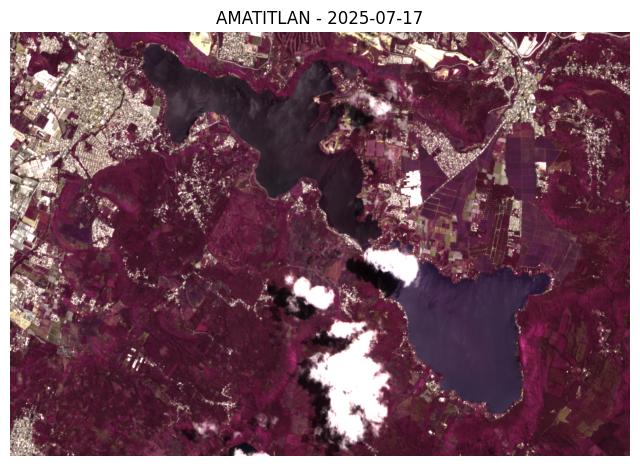

In [216]:
show_rgb_image("amatitlan", "2025-07-17")

In [217]:
classify_point("amatitlan", "2025-07-17", lon=-90.6024, lat=14.48)

{'proba': 0.09387270455590213,
 'label': 0,
 'lon': -90.6024,
 'lat': 14.48,
 'chl_proxy': 5.022330284118652}

In [218]:
classify_point("amatitlan", "2025-07-17", lon=-90.5716, lat=14.4631)

{'proba': 0.02514181002017998,
 'label': 0,
 'lon': -90.5716,
 'lat': 14.4631,
 'chl_proxy': 8.138187408447266}

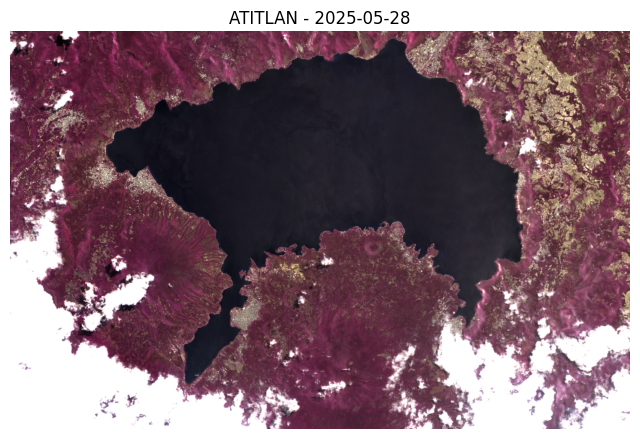

In [219]:
show_rgb_image("atitlan", "2025-05-28")

In [220]:
classify_point("atitlan", "2025-05-28", lon=-91.14457, lat=14.6764)

{'proba': 0.5475705923695916,
 'label': 1,
 'lon': -91.14457,
 'lat': 14.6764,
 'chl_proxy': 4.7307538986206055}

In [221]:
classify_point("atitlan", "2025-05-28", lon=-91.2456, lat=14.6997)

{'proba': 0.04636491972017304,
 'label': 0,
 'lon': -91.2456,
 'lat': 14.6997,
 'chl_proxy': 4.440273284912109}

### Modelo Híbrido para Predecir Índice de Cianobacteria usando Series Temporales y Prediciendo si un Área está Contaminada o no

In [228]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

In [229]:
df_qc = pd.read_csv("CSVData/df_qc.csv", parse_dates=["date"])
LAKES = sorted(df_qc["lake"].unique())

In [230]:
def _log1p(a):
    return np.log1p(np.clip(np.asarray(a, dtype="float64"), 0, None))

def _exp1m(a):
    return np.expm1(a)

def seasonal_naive_next(y, s=7):
    y = pd.Series(y).dropna()
    return float(y.iloc[-s]) if len(y) >= s else float(y.iloc[-1])

In [231]:
def walkforward_chl_pred(df_qc, lake, s=7, min_train=10, cutoff=None):
    g = df_qc[df_qc["lake"]==lake].sort_values("date").reset_index(drop=True)
    out = []
    for i in range(max(min_train, 2*s), len(g)):
        date_i = g.loc[i, "date"]
        if cutoff and date_i >= cutoff:
            continue  # no predecir fechas de test
        train_log = _log1p(g.loc[:i-1, "chl_mean_clip0"].values)
        try:
            mod = SARIMAX(train_log, order=(1,0,1), seasonal_order=(0,1,1,s),
                          trend="n", enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            yhat = res.get_forecast(steps=1).predicted_mean.iloc[0]
            pred = _exp1m(yhat)
        except:
            pred = seasonal_naive_next(_exp1m(train_log), s=s)
        out.append({"lake": lake, "date": date_i, "chl_pred": float(pred)})
    return pd.DataFrame(out)

In [232]:
def walkforward_all_lakes(df_qc, lakes, s=7, min_train=10, cutoff=None):
    return pd.concat(
        [walkforward_chl_pred(df_qc, lake, s=s, min_train=min_train, cutoff=cutoff) for lake in lakes],
        ignore_index=True
    )

In [235]:
def generate_npz_for_date(lake, date, max_samples=50000, out_dir=Path("NPZData")):
    df = sample_pixels_for_date(lake, date, max_samples=max_samples)
    if df is None or df.empty:
        print(f"[WARN] No se generó .npz para {lake} {date}")
        return

    npz_path = out_dir / lake
    npz_path.mkdir(parents=True, exist_ok=True)
    filename = npz_path / f"{lake}__{pd.to_datetime(date).strftime('%Y-%m-%d')}.npz"
    
    np.savez_compressed(
        filename,
        row=df["row"].values,
        col=df["col"].values,
        **{col: df[col].values for col in df.columns if col not in ["lake", "date", "row", "col"]}
    )
    print(f"[OK] Guardado: {filename}")

In [236]:
# Número de fechas de test por lago
N = 4

valid_dates_by_lake = {}

for lake in LAKES:
    print(f"[{lake.upper()}] Generando .npz")
    bases = list_date_bases(BASE / lake)
    valid_dates = []
    for date, _ in bases:
        generate_npz_for_date(lake, date)
        npz_path = Path("NPZData") / lake / f"{lake}__{date}.npz"
        if npz_path.exists():
            valid_dates.append(pd.to_datetime(date))
    valid_dates_by_lake[lake] = sorted(valid_dates)

# Separar train y test
test_dates = []
train_dates = []

for lake, valid_dates in valid_dates_by_lake.items():
    lake_test = valid_dates[-N:]  # últimas N con .npz
    lake_train = valid_dates[:-N] if len(valid_dates) > N else []
    test_dates.extend(lake_test)
    train_dates.extend(lake_train)

test_dates = sorted(set(test_dates))
train_dates = sorted(set(train_dates))

if not test_dates:
    raise ValueError("No hay fechas de test con archivos .npz disponibles. Verifica los datos.")

test_start = min(test_dates)

print("Fechas finales de test:", test_dates)
print("Fechas finales de train:", train_dates)

[AMATITLAN] Generando .npz
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-02-07.npz
[WARN] No se generó .npz para amatitlan 2025-02-10
[WARN] No se generó .npz para amatitlan 2025-02-25
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-02-27.npz
[WARN] No se generó .npz para amatitlan 2025-03-02
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-03-04.npz
[WARN] No se generó .npz para amatitlan 2025-03-07
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-03-09.npz
[WARN] No se generó .npz para amatitlan 2025-03-12
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-03-14.npz
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-03-19.npz
[WARN] No se generó .npz para amatitlan 2025-03-22
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-03-24.npz
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-03-26.npz
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-04-03.npz
[WARN] No se generó .npz para amatitlan 2025-04-11
[OK] Guardado: NPZData\amatitlan\amatitlan__2025-04-13.npz
[OK] Guardado: NPZData\ama

In [237]:
test_start = min(test_dates)

In [238]:
chl_pred_all = walkforward_all_lakes(df_qc, LAKES, s=7, min_train=10)

chl_pred_train = chl_pred_all[chl_pred_all["date"] < test_start]
chl_pred_test  = chl_pred_all[chl_pred_all["date"].isin(test_dates)]

train_pix = build_pixel_table_with_chl_pred(LAKES, train_dates, chl_pred_train, max_samples=12000)
test_pix  = build_pixel_table_with_chl_pred(LAKES, test_dates,  chl_pred_test,  max_samples=12000)

c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likeliho

In [240]:
print("Fechas finales de test:", test_dates)
print("Fechas finales de train:", train_dates)

Fechas finales de test: [Timestamp('2025-05-28 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-20 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-08-01 00:00:00')]
Fechas finales de train: [Timestamp('2025-02-07 00:00:00'), Timestamp('2025-02-10 00:00:00'), Timestamp('2025-02-25 00:00:00'), Timestamp('2025-02-27 00:00:00'), Timestamp('2025-03-02 00:00:00'), Timestamp('2025-03-04 00:00:00'), Timestamp('2025-03-07 00:00:00'), Timestamp('2025-03-09 00:00:00'), Timestamp('2025-03-12 00:00:00'), Timestamp('2025-03-14 00:00:00'), Timestamp('2025-03-19 00:00:00'), Timestamp('2025-03-22 00:00:00'), Timestamp('2025-03-24 00:00:00'), Timestamp('2025-03-26 00:00:00'), Timestamp('2025-04-03 00:00:00'), Timestamp('2025-04-11 00:00:00'), Timestamp('2025-04-13 00:00:00'), Timestamp('2025-04-15 00:00:00'), Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-04-28 00:00:00'), Timestamp('2025-05-03 00:00:00'), Timestamp('2025-05-13 00:00:00'

In [242]:
p80 = train_pix.groupby("lake")["CHL"].quantile(0.80).to_dict()
def make_label(df):
    return ((df["CHL"] >= df["lake"].map(p80))).astype(int)  

train_pix["y"] = make_label(train_pix)
test_pix["y"]  = make_label(test_pix)

In [243]:
BASE_FEATURES = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12",
                 "NDVI","NDWI","MNDWI"]  
CONTEXT = ["chl_pred", "month", "doy"]
FEATURES = BASE_FEATURES + CONTEXT

In [244]:
Xtr = train_pix[FEATURES].astype("float32").values
ytr = train_pix["y"].values
Xte = test_pix[FEATURES].astype("float32").values
yte = test_pix["y"].values

clf_h = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
clf_h.fit(Xtr, ytr)

proba = clf_h.predict_proba(Xte)[:,1]
roc = roc_auc_score(yte, proba)
pr  = average_precision_score(yte, proba)
print(f"[AJUSTADO] ROC-AUC={roc:.3f} | PR-AUC={pr:.3f}")
print(classification_report(yte, (proba>=0.5).astype(int), digits=3))

[AJUSTADO] ROC-AUC=0.963 | PR-AUC=0.883
              precision    recall  f1-score   support

           0      0.908     0.990     0.947     78309
           1      0.930     0.559     0.698     17805

    accuracy                          0.910     96114
   macro avg      0.919     0.775     0.823     96114
weighted avg      0.912     0.910     0.901     96114



In [245]:
for d in test_dates:
    subset = test_pix[test_pix["date"] == d]
    if subset.empty:
        print(f"Sin datos para {d}")
        continue
    X = subset[FEATURES].astype("float32").values
    y_true = subset["y"].values
    y_pred = clf_h.predict(X)
    print(f"\nFecha: {d}")
    print(classification_report(y_true, y_pred, digits=3))


Fecha: 2025-05-28 00:00:00
              precision    recall  f1-score   support

           0      0.916     0.986     0.950     20420
           1      0.863     0.484     0.620      3580

    accuracy                          0.911     24000
   macro avg      0.889     0.735     0.785     24000
weighted avg      0.908     0.911     0.901     24000


Fecha: 2025-07-17 00:00:00
              precision    recall  f1-score   support

           0      0.943     0.978     0.961     18168
           1      0.924     0.817     0.867      5832

    accuracy                          0.939     24000
   macro avg      0.934     0.898     0.914     24000
weighted avg      0.939     0.939     0.938     24000


Fecha: 2025-07-20 00:00:00
              precision    recall  f1-score   support

           0      0.991     1.000     0.996       113
           1      0.000     0.000     0.000         1

    accuracy                          0.991       114
   macro avg      0.496     0.500     0.498 

c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ncast\OneDrive\Documentos\Universidad\Data Science\Lab04-DS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi


Fecha: 2025-08-01 00:00:00
              precision    recall  f1-score   support

           0      0.910     0.999     0.952     21244
           1      0.962     0.236     0.379      2756

    accuracy                          0.911     24000
   macro avg      0.936     0.617     0.666     24000
weighted avg      0.916     0.911     0.886     24000



### Pruebas por Área

In [246]:
import rasterio
from rasterio.transform import rowcol, xy
import numpy as np
import pandas as pd
from datetime import datetime

In [ ]:
chl_dates = set(chl_pred_all[chl_pred_all["lake"] == "amatitlan"]["date"].dt.strftime("%Y-%m-%d"))

bands_dates = set(available_dates)

valid_classify_dates = sorted(bands_dates & chl_dates)

print("Fechas válidas para classify_region (amatitlan):")
for d in valid_classify_dates:
    print("  ", d)


Fechas válidas para classify_region (amatitlan):
   2025-02-25
   2025-02-27
   2025-03-02
   2025-03-04
   2025-03-07
   2025-03-09
   2025-03-12
   2025-03-14
   2025-03-19
   2025-03-22
   2025-03-24
   2025-03-26
   2025-04-03
   2025-04-11
   2025-04-13
   2025-04-15
   2025-04-16
   2025-04-18
   2025-04-28
   2025-05-03
   2025-05-13
   2025-05-28
   2025-07-10
   2025-07-17
   2025-07-20
   2025-07-24
   2025-08-01


In [268]:
chl_dates = set(chl_pred_all[chl_pred_all["lake"] == "atitlan"]["date"].dt.strftime("%Y-%m-%d"))

bands_dates = set(available_dates)

valid_classify_dates = sorted(bands_dates & chl_dates)

print("Fechas válidas para classify_region (atitlan):")
for d in valid_classify_dates:
    print("  ", d)


Fechas válidas para classify_region (atitlan):
   2025-02-25
   2025-02-27
   2025-03-02
   2025-03-04
   2025-03-07
   2025-03-09
   2025-03-12
   2025-03-14
   2025-03-19
   2025-03-22
   2025-03-24
   2025-03-26
   2025-04-03
   2025-04-11
   2025-04-13
   2025-04-15
   2025-04-16
   2025-04-18
   2025-04-28
   2025-05-03
   2025-05-13
   2025-05-28
   2025-07-10
   2025-07-17
   2025-07-20
   2025-07-24
   2025-08-01


In [247]:
def classify_region(lake, date, bbox, model, chl_pred_df, threshold=0.5):
    bands_path = next((BASE / lake).glob(f"{lake}__{date}*.bands.tiff"), None)
    if bands_path is None:
        raise FileNotFoundError(f"No se encontró la imagen para {lake} en {date}")
    
    with rasterio.open(bands_path) as src:
        transform = src.transform
        row_min, col_min = rowcol(transform, bbox[0], bbox[3])  
        row_max, col_max = rowcol(transform, bbox[2], bbox[1])  
        
        row_min, row_max = max(0, row_min), min(src.height, row_max)
        col_min, col_max = max(0, col_min), min(src.width, col_max)

        bands = src.read().astype("float32")
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = [b[row_min:row_max, col_min:col_max] for b in bands]

    ndvi  = (b08 - b04) / (b08 + b04 + 1e-6)
    ndwi  = (b03 - b08) / (b03 + b08 + 1e-6)
    mndwi = (b03 - b11) / (b03 + b11 + 1e-6)

    date_obj = pd.to_datetime(date)
    month = date_obj.month
    doy = date_obj.dayofyear
    chl_pred = chl_pred_df.set_index(["lake", "date"]).get("chl_pred").get((lake, pd.to_datetime(date)), np.nan)
    if np.isnan(chl_pred):
        raise ValueError(f"No hay chl_pred para {lake} en {date}")
    
    H, W = ndvi.shape
    feats = np.stack([
        b02.ravel(), b03.ravel(), b04.ravel(), b05.ravel(), b07.ravel(),
        b08.ravel(), b8a.ravel(), b11.ravel(), b12.ravel(),
        ndvi.ravel(), ndwi.ravel(), mndwi.ravel(),
        np.full(H*W, chl_pred, dtype="float32"),
        np.full(H*W, month, dtype="float32"),
        np.full(H*W, doy, dtype="float32")
    ], axis=1)

    probas = model.predict_proba(feats)[:,1]
    labels = (probas >= threshold).astype(int)

    contaminados = labels.sum()
    total = len(labels)
    promedio = probas.mean()
    return {
        "lake": lake,
        "date": date,
        "region_bbox": bbox,
        "pixels_total": int(total),
        "pixels_contaminated": int(contaminados),
        "contamination_rate": float(contaminados / total),
        "avg_proba": float(promedio),
        "contaminated": bool(contaminados > total * 0.5) 
    }

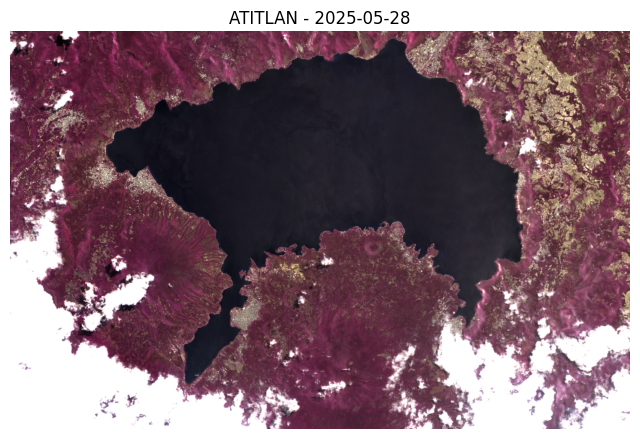

In [267]:
show_rgb_image("atitlan", "2025-05-28")

In [248]:
bbox = (-91.2, 14.65, -91.14, 14.70)  

result = classify_region(
    lake="atitlan",
    date="2025-05-28",
    bbox=bbox,
    model=clf_h,
    chl_pred_df=chl_pred_all
)

print(result)

{'lake': 'atitlan', 'date': '2025-05-28', 'region_bbox': (-91.2, 14.65, -91.14, 14.7), 'pixels_total': 301644, 'pixels_contaminated': 5831, 'contamination_rate': 0.019330734243014944, 'avg_proba': 0.3736183598810158, 'contaminated': False}


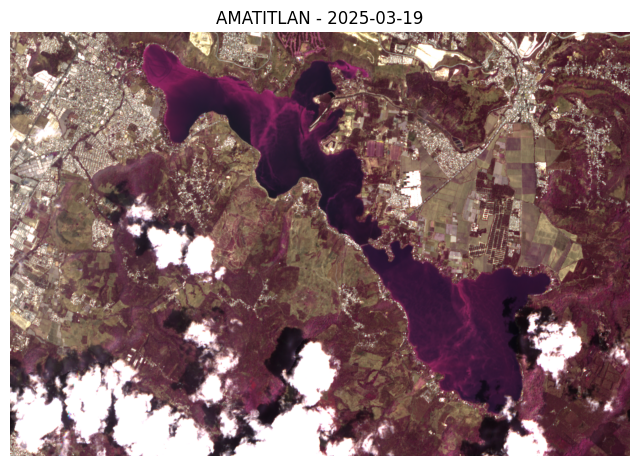

In [264]:
show_rgb_image("amatitlan", "2025-03-19")

In [265]:
bbox = (-90.6010, 14.4840, -90.5980, 14.4865) 

result = classify_region(
    lake="amatitlan",
    date="2025-03-19",
    bbox=bbox,
    model=clf_h,
    chl_pred_df=chl_pred_all
)

print(result)

{'lake': 'amatitlan', 'date': '2025-03-19', 'region_bbox': (-90.601, 14.484, -90.598, 14.4865), 'pixels_total': 924, 'pixels_contaminated': 677, 'contamination_rate': 0.7326839826839827, 'avg_proba': 0.709139066822876, 'contaminated': True}
